# Assignment 4 - Leonardo Stoppani
## Bayesian Network from scratch in Python

## Code

I choose to implement the Bayesian Network in Python by writing a simple interface that allows the user to define its own custom network and run some experiments on it.

Bayesian Network is implemented by two classes: `BayesianNetwork` and `Bnode`. The first one is the main class that contains the network structure and the second one is the class that represents a single node in the network.

The `Bnode` class is defined as follows:

```python
    def __init__(self, cpt: dict, parents: list):
        self.cpt = cpt
        self.parents = parents
```

where `parents` is a list of the parents of the node and `cpt` is the conditional probability table of the node.

The `BayesianNetwork` class is defined as follows:

```python
    def __init__(self, nodes: dict, values: list):
        self.nodes = nodes
        self.values = values 
        G = nx.DiGraph(self.get_edges())

        # check acyclicity of graph
        if nx.is_directed_acyclic_graph(G): self.g = G
        else: raise ValueError('Network is not acyclic.')

        # add nodes without edges to the graph
        for node in self.get_nodes():
            if node not in self.g.nodes: self.g.add_node(node)

```
    
where `nodes` is a dictionary that maps the name of the node to the `Bnode` object, `values` is a list of the possible values of the nodes (e.g. `['T', 'F']`) and `g` is the *networkx* graph that represents the network structure. The constructor also checks if the network is acyclic and adds nodes without edges to the graph.

The `sampling()` method of `BayesianNetwork` class implement the Ancestral Sampling algorithm. It takes as input the number of samples to generate and returns a dictionary that maps the sample number to the sample itself. It allows also to specify an initial state of the network by adding some evidemce to the network. Also a seed can be specified for reproducibility.

```python
    def sampling (self, n=1, init: dict = {}, seed: int = None) -> dict:
        """ Ancestral sampling n times from the network.
        
        Args:
            n (int): number of times to sample.
            init (dict): initial state of the network.
            seed (int): random seed.

        Returns:
            dict: n samples
        """
        samples={} # n samples

        print('Ancestral sampling %d times from the network...' %(n))
        print()

        # DONE: topological order of nodes
        nodes = list(nx.topological_sort(self.g))
        print('Topological ordering of nodes: ', end="")
        print(nodes)
        print()

        for iter in range(n):
            s = {} # i-esimo sample
            for nname in nodes: # get node in topological order
                
                node = self.nodes[nname]

                #check init state
                if nname in init:
                    s[nname] = init[nname]
                else:
                    # get cpt of node
                    cpt = node.get_cpt() # cpt of the current node
                    
                    # get parents of node
                    parents = node.get_parents()

                    if parents == None: 
                        s[nname] = self.multi_choice(self.values, cpt['p'])
                    else:
                        s[nname] = self.multi_choice(self.values, cpt[tuple([s[parent] for parent in parents])])
                            
            # add current sampling to samples
            samples[iter+1] = s
        
        return samples        
```

The `multi_choice()` method is a helper function that allows to sample from a multinomial or binomial distribution. It takes as input a list of possible values and a list of probabilities and returns a random value sampled from the distribution.

```python
    def multi_choice(self, values: list, probabilities : list, seed : int = None) -> str:
        """ Return a value from a list according to its probability distribution.
        
            Args:
                values (list): list of values that each node can take.
                probabilities (list): list of probabilities of each value.
                seed (int): random seed to repeat same sampling.

            Returns:
                str: a value from the list of values
        """
        if (len(values)!=len(probabilities)): raise ValueError('Length of values and probabilities must be the same.')

        if seed != None: random.seed(seed)

        return np.random.choice(values,p=probabilities)
``` 

The `BayesianNetwork` class also has the methods `get_nodes()` and `get_edges()` to get nodes and edges of the network and the method `plot()` to plot the Bayesian Network with the *graphviz* module.

## Usage

To define a Bayesian Network and run the Ancestral Sampling algorithm first import the module.

In [1]:
from bayes_net import BayesNetwork
from bnode import Bnode

import pprint

Then create the nodes of the network using the constructor of the class `Bnode`. Here you need to add the conditional probability tables and the parents for every node.

In [2]:
# define cpt tables for each node

burglary = Bnode(
    cpt= { 'p' : [0.2,0.8] },
    parents=None
)

earthquake = Bnode(
    cpt= { 'p' : [0.1,0.9] },
    parents=None
)

alarm = Bnode(
    cpt= {
        ('True', 'True'): [0.95,0.05],
        ('True', 'False'): [0.94,0.06],
        ('False', 'True'): [0.29,0.71],
        ('False', 'False'): [0.001,0.999]
    },
    parents=['Burglary','Earthquake']
)

mcall = Bnode(
    cpt= {
        ('True',): [0.7,0.3],
        ('False',): [0.01,0.99]
    },
    parents=['Alarm']
)

jcall = Bnode(
    cpt= {
        ('True',): [0.9,0.1],
        ('False',): [0.05,0.95]
    },
    parents=['Alarm']
)

Finally create the Bayesian Network by passing as input a dict of `(name, node)` to the constructor of the class `BayesianNetwork`. When creating the network you don't need to specify the structure of the network, it will be inferred from the nodes you created. Also the constructor will check if the network is acyclic. Values needs to be specified so that the class can infer the number of states of the nodes, class support binomial and multinomial distributions.

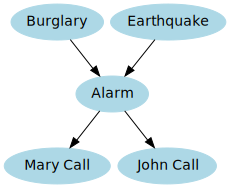

In [3]:
bn = BayesNetwork({'Alarm': alarm, 'Earthquake': earthquake, 'Mary Call': mcall, 'John Call': jcall, 'Burglary': burglary}, values=['True','False'])

bn.plot()

After creating the network you can run the **Ancestral Sampling algorithm** by calling the `sampling` method. This method will return a dictionary with the name of the nodes as keys and the sampled values as values. The methods has three optional parameters: 
- `n_samples`: the number of samples to generate
- `init`: a dictionary of `(name, value)` that specifies the evidence to use for the sampling
- `seed`: the seed to use for the random number generator to reproduce the results

In [4]:
pp = pprint.PrettyPrinter(sort_dicts=False, indent=4)
samples = bn.sampling(5)
pp.pprint(samples)

Ancestral sampling 5 times from the network...

Topological ordering of nodes: ['Burglary', 'Earthquake', 'Alarm', 'Mary Call', 'John Call']

{   1: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    2: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'True'},
    3: {   'Burglary': 'False',
           'Earthquake': 'True',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    4: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'},
    5: {   'Burglary': 'False',
           'Earthquake': 'False',
           'Alarm': 'False',
           'Mary Call': 'False',
           'John Call': 'False'}}


## Examples 
Below are shown two examples which use the classes implemented before, to define a Bayesian Network and perform ancestral sampling over them. The two examples are taken from real life problems and counts 10 nodes each. 

### COVID Diagnosis Example
In this example we want to build a Bayesian Network that can be used to diagnose COVID-19. The network has 10 nodes and the structure is the following:

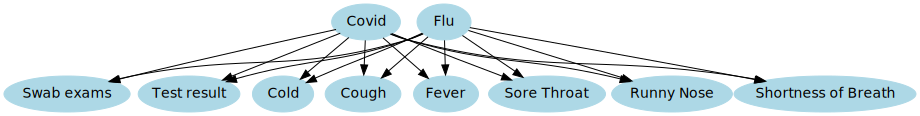

In [5]:
covid = Bnode(
    cpt= { 'p' : [0.001,0.999] },
    parents=None
)

flu = Bnode(
    cpt= { 'p' : [0.1,0.9] },
    parents=None
)

cough = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu'] 
)

fever = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

sore_throat = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    }, 
    parents=['Covid','Flu']
)

runny_nose = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

shortness_of_breath = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

cold = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

swab_exams = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)

test_result = Bnode(
    cpt= {
        ('True', 'True'): [0.9,0.1],
        ('True', 'False'): [0.8,0.2],
        ('False', 'True'): [0.1,0.9],
        ('False', 'False'): [0.05,0.95]
    },
    parents=['Covid','Flu']
)
    
# create the BN
cbn = BayesNetwork({'Covid': covid, 'Flu': flu,'Cold': cold, 'Cough': cough, 'Fever': fever, 'Sore Throat': sore_throat, 'Runny Nose': runny_nose, 'Shortness of Breath': shortness_of_breath,
                    'Swab exams': swab_exams, 'Test result': test_result}, values=['True','False'])

# plot the BN
cbn.plot()

Then some episoded of ancestral sampling can be performed over the network.

In [6]:
# ancestral sampling 
pp = pprint.PrettyPrinter(sort_dicts=False)
samples = cbn.sampling(10)
pp.pprint(samples)

Ancestral sampling 10 times from the network...

Topological ordering of nodes: ['Covid', 'Flu', 'Cold', 'Cough', 'Fever', 'Sore Throat', 'Runny Nose', 'Shortness of Breath', 'Swab exams', 'Test result']

{1: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'False',
     'Fever': 'False',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab exams': 'False',
     'Test result': 'True'},
 2: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'False',
     'Fever': 'False',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab exams': 'False',
     'Test result': 'False'},
 3: {'Covid': 'False',
     'Flu': 'False',
     'Cold': 'False',
     'Cough': 'False',
     'Fever': 'True',
     'Sore Throat': 'False',
     'Runny Nose': 'False',
     'Shortness of Breath': 'False',
     'Swab exams': 'False',
     'Test result': 'False'},
 4: {

consideration 

### Daily Routine Example
In this example a Bayesian Network is defined to represent my daily routine. The network has 10 nodes and the structure is the following:


In [7]:
# Define BN of 10 nodes about daily routine (Wakeup, Coffee, Toilet, Study, Lunch, etc)





Also in this case some episoded of ancestral sampling can be performed over the network.

In [8]:
# ancestral sampling

considerations

## Final Considerations

- cosa dovevo fare 
- cosa ho fatto: 
    - build a simple and easy to use library to represent Bayesian Networks and perform ancestral sampling
- cosa ho imparato: 
    - use networkx and graphviz to represent graphs
    - use numpy to sample from distributions
    - better understanding of Bayesian Networks and ancestral sampling
- cosa possiamo migliorare: 
    - add more BN algorithm (joint prob, marginal prob, inference, etc)
    - add network manipulation methods (add/remove nodes, add/remove edges, etc)